## Makine Öğrenmesi Dersleri 4a: Lineer Regresyon

Gözetimli makine öğrenmesi (supervised machine learning) ve istatistik modelleri temel olarak iki problemi çözmeye çalışır:

- Regresyon
- Sınıflandırma

Makine öğrenmesi derslerinin 3. serisinde karar ağaçlarıyla nasıl regresyon ve sınıflandırma yaptığımızdan bahsetmiştik.

Bu yazıda en temel regresyon modeli olan lineer regresyondan bahsedip Bay Area ev fiyatları hakkında tahminde bulunacağız.

Lineer regresyon tahmin etmek istediğimiz y değişkeni (ev fiyatları) ve veri setindeki x öznitelikleri (enlem, boylam, oda sayısı, evin yaşı, okyanusa uzaklığı vs.) arasındaki ilişkiyi anlamamıza yardımcı olur. Günün sonunda amacımız bir değişkendeki artışın veya azalışın ev fiyatını nasıl etkilediğini doğru olarak anlamak ve yeni evler gördüğümüzde tutarlı tahminlerde bulunmak.

![image.png](https://cdn-images-1.medium.com/max/880/1*-N98-9lrYGcvUNuRjobFOQ.png)

- y: ev fiyatı
- x1: oda sayısı
- x2:evin yaşı
- ...
- xn: okyanusa uzaklık gibi düşünebilirsiniz.

Modelimizin kalitesini belirleyen ölçüt yaptığımız tahminlerle gerçek değer arasındaki fark: hata (residuals), diğer bir deyişle modelimizin açıklamakta yetersiz kaldığı kısım. Lineer regresyonda amacımız bu hatalarla ilgili maliyet fonksiyonlarını (MAE, SE, RMSE vs.) minimize eden en iyi denklemi bulmak. Modelimizdeki hata terimlerinde yapısal bir bilginin örüntünün kalmasını istemiyoruz.

![image.png](https://cdn-images-1.medium.com/max/880/1*A71zTD6_QqUzLhMKj1Rgiw.png)

İlk derste olduğu gibi bu dersi takip etmek için de bilgisayarınıza Python kurmanıza veya veri setini indirmenize gerek yok. İhtiyacınız olan tek şey internet ve bu yazıyı okuduğunuza göre o konuda da bir sorunumuz yok. İzlemeniz gereken adımlar sırasıyla şöyle:

- Google hesabınızı açın.
- https://colab.research.google.com/ adresine gidin.
- NEW PYTHON 3 NOTEBOOK'a tıklayın.
- Oradaki satıra aşağıdaki kodu yapıştırın ve play tuşuna basın.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 

data = pd.read_csv('https://raw.githubusercontent.com/HakkiKaanSimsek/Makine_Ogrenmesi_Dersleri/master/karar_agaclari/data/housing.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Modelimizdeki hedef değişken 'median_house_value' olduğu için onun dağılımına bakıyoruz ve veri setinin geri kalanından ayırıyoruz.

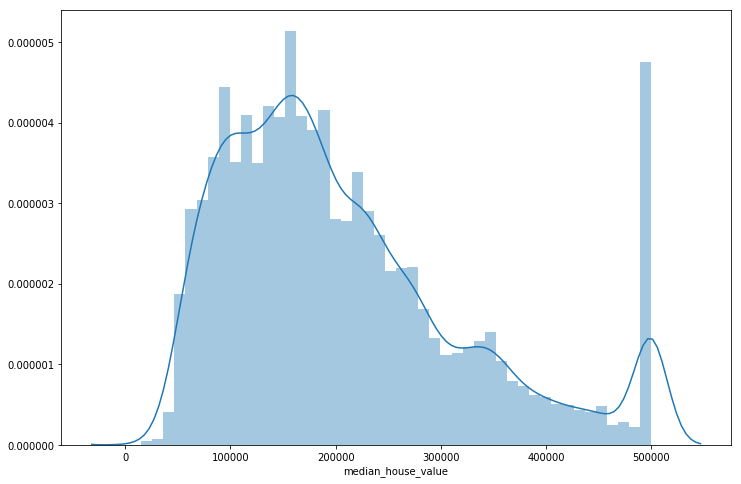

In [2]:
plt.figure(figsize=(12,8))
X = data.drop(['median_house_value'], axis=1)
y = data['median_house_value']
sns.distplot(y)
plt.show()

Makine öğrenmesi modelleri kategorik değişkenleri algılayamadığı için 'object' tipindeki değişkenleri one-hot-encoding yöntemiyle 0 ve 1'lere ayırıyoruz. Ayrıca 'total_bedroom' değişkenindeki eksik değerleri doldurmamız gerekiyor. 

Yapmamız gerekenler sırasıyla şöyle:

- cean_proximity değişkeni pd.get_dummies() fonksiyonuyla zenginleştirilir. 
- Bu değişken veri setinden atılır.
- total_bedroom değişkeni yine o sütunun median() değeriyle doldurulur.

In [3]:
X = pd.concat([X, pd.get_dummies(X.ocean_proximity)], axis=1)
X = X.drop(['ocean_proximity'],axis=1)
X['total_bedrooms'] = X['total_bedrooms'].fillna(X['total_bedrooms'].median())

Modelimizi kurmaya hazırız şimdi standart modelleme süreçlerini uygulayacağız.

1. Veriyi eğitim ve test alt-veri setlerine ayırma.
2. Karar ağacı modeli oluşturma.
3. Modeli eğitim verisine 'fit' etme.
4. R score hesaplama
5. Intercept ve coefficient hesaplama.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = X[['longitude', 'latitude', 'housing_median_age', 'households', 'median_income',
       '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
lm = LinearRegression()
lm.fit(X_train, y_train)
print("R score: {0}".format(round(lm.score(X_train, y_train),2)))
print("Intercept: {0}".format(round(lm.intercept_),))
pd.DataFrame({'feature':X.columns, 'coef':lm.coef_})

R score: 0.61
Intercept: -1959416.0


,feature,coef
0,longitude,-23200.151341
1,latitude,-21334.382684
2,housing_median_age,1101.016089
3,households,25.254305
4,median_income,37691.247397
5,<1H OCEAN,-24570.622782
6,INLAND,-69876.872130
7,ISLAND,132925.194262
8,NEAR BAY,-22998.713078
9,NEAR OCEAN,-15478.986271


6. Görmediğimiz test verisini modele verip tahminde bulunma.
7. Gerçek değerlerle tahmin değerleri arasındaki ilişkiye bakmak için scatter plot kullanma.

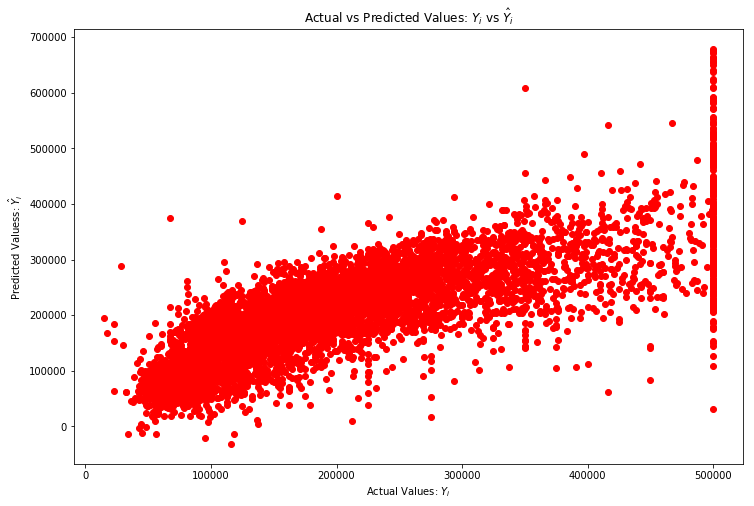

In [5]:
plt.figure(figsize=(12,8))
plt.scatter(y_test, lm.predict(X_test), color='r')
plt.xlabel("Actual Values: $Y_i$")
plt.ylabel("Predicted Valuess: $\hat{Y}_i$")
plt.title("Actual vs Predicted Values: $Y_i$ vs $\hat{Y}_i$")
plt.show()

8. Tahmin edilen değerlerle hata terimleri arasında ilişkisel bir yapı olup olmadığını kontrol etmek için scatter plot kullanma.

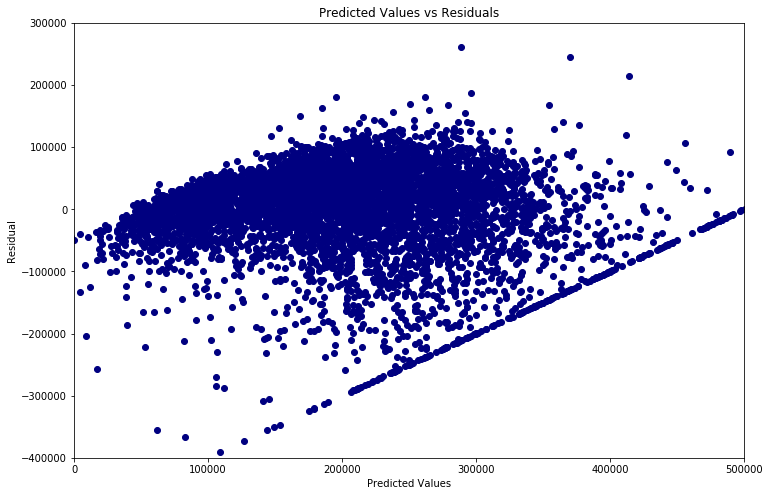

In [11]:
plt.figure(figsize=(12,8))
plt.scatter(lm.predict(X_test), lm.predict(X_test) - y_test, c = 'navy')
plt.xlabel('Predicted Values')
plt.ylabel('Residual')
plt.title('Predicted Values vs Residuals')
plt.xlim(0,500000)
plt.ylim(-400000,300000)
plt.show()

9. Gerçek değerle tahmin arasındaki benzerliğe göre mean absolute error, mean squared error ve root mean squared error hesaplama. 

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(lm.predict(X_test), y_test)
mse = mean_squared_error(lm.predict(X_test), y_test)
rmse = np.sqrt(mse)

print('Mean Absolute Error (MAE): %.2f' % mae)
print('Mean Squared Error (MSE): %.2f' % mse)
print('Root Mean Squared Error (RMSE): %.2f' % rmse)

Mean Absolute Error (MAE): 52298.52
Mean Squared Error (MSE): 5088802214.06
Root Mean Squared Error (RMSE): 71335.84


10. Yukarıda scikit-learn ile yapılan çalışmayı statsmodels.api kullarak da hızlıca yapabiliriz.

In [8]:
import statsmodels.api as sm

model = sm.OLS(y_train, X_train).fit()
print('Mean Absolute Error (MAE): %.2f' % mae)
print('Mean Squared Error (MSE): %.2f' % mse)
print('Root Mean Squared Error (RMSE): %.2f' % rmse)

model.summary()

Mean Absolute Error (MAE): 52298.52
Mean Squared Error (MSE): 5088802214.06
Root Mean Squared Error (RMSE): 71335.84


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     median_house_value   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     2550.
Date:                Thu, 30 Aug 2018   Prob (F-statistic):               0.00
Time:                        09:21:11   Log-Likelihood:            -1.8208e+05
No. Observations:               14448   AIC:                         3.642e+05
Df Residuals:                   14438   BIC:                         3.643e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
longitude           -2.32e+04   1240.626    -18.700      0.000   -2.56e+04   -2.08e+04
latitude           -2.133e+04   1223.365    -17.439      0.000   -2.37e+04   -1.89e+04
housing_median_age  1101.0161     54.258     20.292      0.000     994.663    1207.369
households            25.2543      1.667     15.151      0.000      21.987      28.521
median_income       3.769e+04    333.001    113.186      0.000     3.7e+04    3.83e+04
<1H OCEAN          -1.984e+06   1.07e+05    -18.516      0.000   -2.19e+06   -1.77e+06
INLAND             -2.029e+06   1.06e+05    -19.172      0.000   -2.24e+06   -1.82e+06
ISLAND             -1.826e+06   1.14e+05    -16.056      0.000   -2.05e+06    -1.6e+06
NEAR BAY           -1.982e+06   1.08e+05    -18.412      0.000   -2.19e+06   -1.77e+06
NEAR OCEAN         -1.975e+06   1.08e+05    -18.360      0.000   -2.19e+06   -1.76e+06
==============================================================================
Omnibus:                     3437.671   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9772.290
Skew:                           1.252   Prob(JB):                         0.00
Kurtosis:                       6.157   Cond. No.                     2.56e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.56e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Bu tabloyu nasıl okuyacağımıza 'total_bedrooms' yatak odası üzerinden bakalım. Modele göre evdeki yatak odası sayısı bir arttığında bölgedeki medyan ev fiyatı 105.72 dolar artıyor.

Ayrıca tablodaki R-squared değeri de önemli, anlamı: Modelin y değişkenindeki varyansın ne kadarını açıkladığı, bizim modelimizde %67'sini açıklıyor.

Bu çalışma standart bir veri bilimi projesinin en basit hali olarak düşünülebilir. 

Yaptıklarımızı tekrarlayalım:

- Veri tiplerini kontrol etme/düzeltme.
- Açıklayıcı veri analizi ve görselleştirme.
- Eksik verileri tahmin etme/veri atama.
- Veri setini eğitim ve test veri-setlerine ayırma.
- Modeli eğitme ve test verisi üzerinde tahmin yapma.
- Gerçek değerlerle tahmin edilen değerler arasındaki ilişkiye bakma.
- Tahmin edilen değerlerle hata terimleri arasındaki ilişkiye bakma.
- Regresyon başarı metriklerine bakma.